# 1) Objective

* Help a restaurant analyze its reviews to quantify customer sentiments, aiding in understanding customer perceptions.
* And to identify food items from each sentiment type, providing actionable insights for menu enhancement.

# 2) Web Scrapping

In [81]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException
from time import sleep
driver = webdriver.Chrome()
reviews = {"reviews":[]}

page=0
i=0
x=0
data=[""]
while(len(reviews['reviews'])<=500):
    # Set up Selenium webdriver (replace with the appropriate driver for your browser)
    driver.get("https://www.tripadvisor.in/Restaurant_Review-g304558-d1571770-Reviews"+data[i]+"-6_Ballygunge_Place-Kolkata_Calcutta_Kolkata_District_West_Bengal.html")

    # Wait for the page to load
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.XPATH, "//div[@class='review-container']")))

    # Retrieve the review containers
    review_containers = driver.find_elements(By.XPATH, "//div[@class='review-container']")

    # Hover over the review text container to trigger the visibility of the "More" button
    review_text_container = driver.find_element(By.XPATH, ".//div[@class='entry']")
    ActionChains(driver).move_to_element(review_text_container).perform()

    try:
        # Click on the "More" button if it is visible
        more_button = review_text_container.find_element(By.XPATH, ".//span[contains(@class, 'ulBlueLinks')]")
        more_button.click()
    except NoSuchElementException:
        pass
    sleep(3)
    
    try:
        for review_element in review_containers:
            text_element = review_element.find_element(By.CSS_SELECTOR, '.partial_entry')
            text = text_element.text
            reviews['reviews']=reviews['reviews']+[text]
    except StaleElementReferenceException:
        text_element = review_element.find_element(By.CSS_SELECTOR, '.partial_entry')
        text = text_element.text
        reviews['reviews']=reviews['reviews']+[text]
        

    page=page+1
    x=x+15
    i=i+1
    data=data+['-or'+str(x)]        

# 3) Data Preprocessing

In [82]:
#Storing reviews in a Dataframe
import pandas as pd
rev=pd.DataFrame(reviews)

In [83]:
#Looking into first five reviews
rev.head()

,reviews
0,"This place doesn’t need any review, the food a..."
1,The best to go out for lunch and to enjoy auth...
2,"If you are a mood of some pure Bengali food, t..."
3,Great food and service! Will definitely go aga...
4,They made a special arrangements on their 25th...


In [84]:
#Converting into lowercase
rev['reviews']=rev['reviews'].str.lower()

In [85]:
#Removing unwanted text
rev['reviews']=rev['reviews'].str.replace('6 Ballygunge Place','')
rev['reviews']=rev['reviews'].str.replace('6 Ballygunge','')
rev['reviews']=rev['reviews'].str.replace('\.\.\.More','')
rev['reviews']=rev['reviews'].str.replace('Ballygunge','')
rev['reviews']=rev['reviews'].str.replace('\n',' ')

C:\Users\tanmo\AppData\Local\Temp\ipykernel_18536\1836725950.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  rev['reviews']=rev['reviews'].str.replace('\.\.\.More','')


In [86]:
#Remove special Characters
import re
rev['reviews']=rev['reviews'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

In [87]:
#Stop words removal
import spacy
nlp=spacy.load('en_core_web_sm')

In [88]:
def transform(x):
    words=[]
    doc=nlp(x)
    for j in doc:
        if ((j.pos_=="NOUN") or (j.pos_=="PROPN") or (j.pos_=="ADJ") or (j.pos_=="INTJ") or (j.pos_=="ADV")):
            words=words+[str(j)]
    return " ".join(words)

In [89]:
rev['new_review']=rev['reviews'].apply(transform)

# 4) Sentiment analysis

In [90]:
from textblob import TextBlob

In [91]:
#Creating a function to get polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [92]:
# Applying polarity function
rev['polarity']=rev['new_review'].apply(polarity)

In [93]:
rev

,reviews,new_review,polarity
0,this place doesn t need any review the food a...,place doesn t review food hospitality however ...,0.037500
1,the best to go out for lunch and to enjoy auth...,best lunch authentic bengali food also buffet ...,0.550000
2,if you are a mood of some pure bengali food t...,mood pure bengali food place certainly needs v...,0.522894
3,great food and service will definitely go aga...,great food service definitely again interior v...,0.406250
4,they made a special arrangements on their 25th...,special arrangements 25th birthday 6th june th...,0.551429
...,...,...,...
505,6 ballygunge place salt lake is very close t...,ballygunge place salt lake very close house fe...,0.100000
506,best bengali buffet cuisine i had on bengali n...,best bengali buffet cuisine bengali new year c...,0.712121
507,i had visited this place with my company colle...,place company colleagues bangalore place buffe...,1.000000
508,located in the posh locality of ballygunge thi...,posh locality ballygunge joint very well high ...,0.262222


In [94]:
#Creating function to classify negative, positive and neutral sentiment on basis of polarity score
def sentiment(text):
    if text>0.05:
        return "Positive"
    elif text<-0.05:
        return "Negative"
    else:
        return "Neutral"

In [95]:
#Applyong above function
rev['Sentiment']=rev['polarity'].apply(sentiment)

In [96]:
rev.head()

,reviews,new_review,polarity,Sentiment
0,this place doesn t need any review the food a...,place doesn t review food hospitality however ...,0.037500,Neutral
1,the best to go out for lunch and to enjoy auth...,best lunch authentic bengali food also buffet ...,0.550000,Positive
2,if you are a mood of some pure bengali food t...,mood pure bengali food place certainly needs v...,0.522894,Positive
3,great food and service will definitely go aga...,great food service definitely again interior v...,0.406250,Positive
4,they made a special arrangements on their 25th...,special arrangements 25th birthday 6th june th...,0.551429,Positive


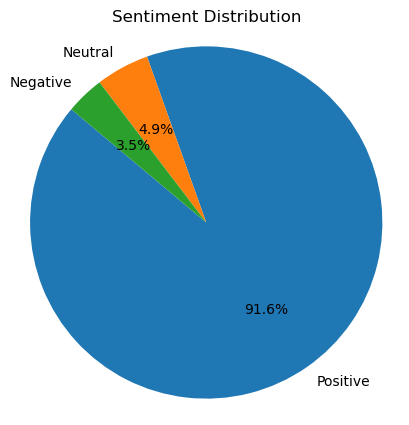

In [97]:
#Visualization of distribution of Sentiments
import matplotlib.pyplot as plt
sentiment_counts = rev['Sentiment'].value_counts()

# Creating a pie chart
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

# 4) Looking into food items in each sentiment type

In [98]:
def filter(x):
    wordlist=[]
    for j in x.split():
        if j in dish_iist:
            wordlist+=[j]
    return ' '.join(wordlist)

In [99]:
rev['filter_review']=rev['new_review'].apply(filter)

In [100]:
#Dividing the reviews on basis of postive , negative and neutral sentiments
Negative=rev[rev['Sentiment']=='Negative']
Positive=rev[rev['Sentiment']=='Positive']
Neutral=rev[rev['Sentiment']=='Neutral']

In [101]:
#Importing dishes menu of the restaurant
dishes=pd.read_table("C:/Users/tanmo/Downloads/m1696-168421492964631491f04af.txt")

In [102]:
# Storing all the dishes in the string
dishes['DISHES']=dishes['DISHES'].str.lower()
dish_iist=' '.join(dishes['DISHES'])

In [103]:
# Removing any special characters
dishes['DISHES']=dishes['DISHES'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
dishes['DISHES']=dishes['DISHES'].apply(lambda x: re.sub(r'\d+', ' ', x))

In [136]:
# Creating Wordclouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [137]:
cloud=WordCloud(stopwords=['bengali','t','service','table','lunch','dinner','menu','food','very','had','best','here','so'])

In [138]:
Positive_Wordcloud=cloud.generate(" ".join(Positive['filter_review']))

Text(0.5, 1.0, 'Positive Sentiment Wordcloud')

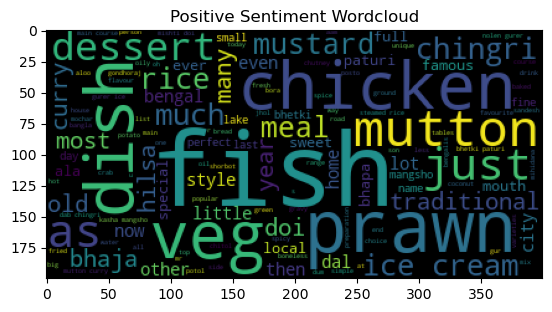

In [139]:
plt.imshow(Positive_Wordcloud)
plt.title("Positive Sentiment Wordcloud")

In [140]:
Negative_Wordcloud=cloud.generate(" ".join(Negative['filter_review']))

Text(0.5, 1.0, 'Negative Sentiment Wordcloud')

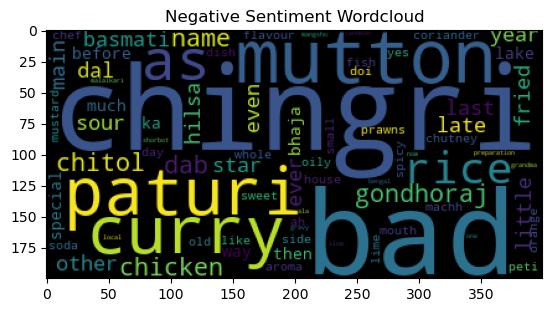

In [141]:
plt.imshow(Negative_Wordcloud)
plt.title("Negative Sentiment Wordcloud")

In [142]:
Neutral_Wordcloud=cloud.generate(" ".join(Neutral['filter_review']))

Text(0.5, 1.0, 'Neutral Sentiment Wordcloud')

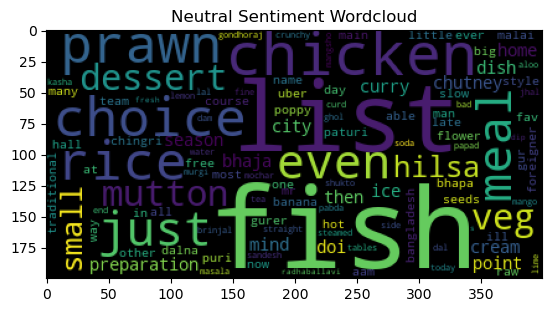

In [143]:
plt.imshow(Neutral_Wordcloud)
plt.title("Neutral Sentiment Wordcloud")